# Ayudantía Práctica Machine Learning

La idea de esta ayudantía es guiar el preprocesamiento de datos que deben realizar para su tarea. Además, veremos reducción de dimensionalidad y clustering en un set de datos.

In [1]:
from sklearn.datasets import load_digits
from sklearn.manifold import TSNE
from sklearn.preprocessing import normalize
from sklearn.cluster import DBSCAN
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from random import shuffle
import pandas as pd
import altair as alt
import numpy as np

alt.renderers.enable('notebook')
digits = load_digits()

En primer lugar cargamos datos que vienen con **sklearn**, estos son los datos MNIST, un dataset de dígitos, cuyos datos representan a una matriz de 8x8 con un dibujo de un número y una label que representa al numero mismo.

In [76]:
#data, targets = (pd.DataFrame(digits['data']), pd.DataFrame(digits['target']))
data = pd.DataFrame(digits['data'])
targets = pd.DataFrame(digits['target'])

data = pd.DataFrame(normalize(data))

data.head()

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0.0,0.0,0.090240,0.234625,0.162433,0.018048,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.108288,0.234625,0.180481,0.000000,0.000000,0.0
1,0.0,0.0,0.000000,0.184966,0.200380,0.077069,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.169552,0.246621,0.154138,0.000000,0.0
2,0.0,0.0,0.000000,0.060385,0.226443,0.181154,0.0,0.0,0.0,0.000000,...,0.075481,0.0,0.0,0.0,0.000000,0.045289,0.166058,0.241539,0.135866,0.0
3,0.0,0.0,0.128815,0.276032,0.239228,0.018402,0.0,0.0,0.0,0.147217,...,0.165619,0.0,0.0,0.0,0.128815,0.239228,0.239228,0.165619,0.000000,0.0
4,0.0,0.0,0.000000,0.018036,0.198400,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.036073,0.288581,0.072145,0.000000,0.0


Ahora usaremos t-SNE, un algoritmo de reducción de dimensionalidad para mapear cada vector de dimensión 64 a otro de dimensión 2.

t-SNE funciona de modo que los puntos que se encuentran cercanos en el espacio de 64 dimensiones también lo esten en 2 dimensiones y lo mismo para puntos que se encuentran lejanos.

En el ejemplo se agrega también una letra, sin embargo esto sólo es para que altair nos muestre cada punto distinto con un color correspondiente a la label, lo que hace que todos los números iguales se muestren de un mismo color.

In [3]:
def color(num):
    return chr(num + 66)

ts = TSNE(n_components=2).fit_transform(data)
tsne = pd.DataFrame(ts, columns=['x', 'y'])
tsne['label'] = targets.applymap(lambda x: color(x))
tsne.head(15)

,x,y,label
0,62.597481,-10.812674,B
1,6.218982,11.431527,C
2,-17.612057,11.612756,D
3,-39.441723,-11.360623,E
4,26.794363,21.414997,F
5,-31.672626,-21.859724,G
6,-1.267113,46.105656,H
7,23.925611,-29.908943,I
8,-15.723158,-2.567590,J
9,-25.875727,-21.587620,K


Ahora que poseemos vectores de sólo dos dimensiones, podemos usar Altair para plotearlos.

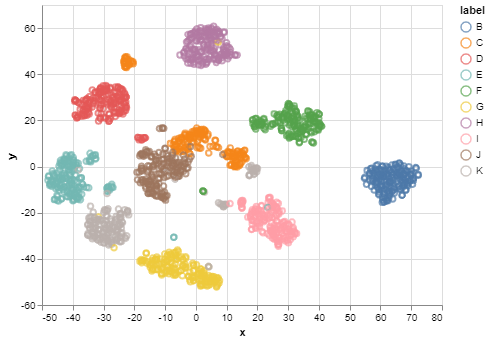

In [4]:
alt.Chart(tsne).mark_point().encode(
    x='x',
    y='y',
    color='label'
)

Ahora usaremos DBSCAN, un algoritmo de **clustering** para crear clusters de los puntos. Este algoritmo crea clusters a partir de la densidad de los puntos. Es decir que un conjunto de puntos cercanos formarán parte del mismo cluster, mientras que los puntos mas alejados no serán parte de él.

El parámetro que recibe DBSCAN es **eps**, que representa la distancia máxima que pueden tener dos puntos que están en el mismo cluster y **min\_samples**, que representa la cantidad de puntos que debe tener a su alrededor otro punto para ser considerado como **punto central** de un cluster.

Igual que en el ejemplo anterior, usamos letras para colorear los puntos, sin embargo estas no dependen de las labels originales de los datos, sino que de los clusters entregados por el algoritmo.

In [5]:
clustering = DBSCAN(eps=7, min_samples=5).fit(ts)

cluster_labels = pd.DataFrame(data=clustering.labels_)

dbscan = pd.DataFrame(ts, columns=['x', 'y'])

dbscan['label'] = cluster_labels.applymap(lambda x: color(x))

dbscan.head()

,x,y,label
0,62.597481,-10.812674,B
1,6.218982,11.431527,C
2,-17.612057,11.612756,C
3,-39.441723,-11.360623,D
4,26.794363,21.414997,E


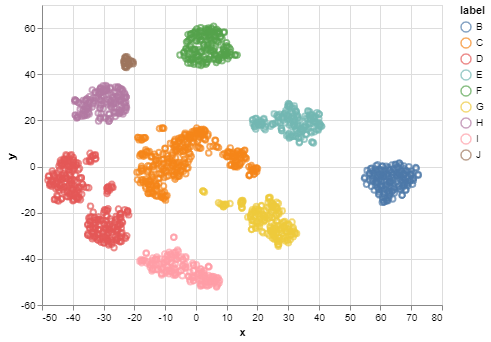

In [6]:
alt.Chart(dbscan).mark_point().encode(
    x='x',
    y='y',
    color='label'
)

Veamos que pasa si bajamos **eps** de 7 a 4

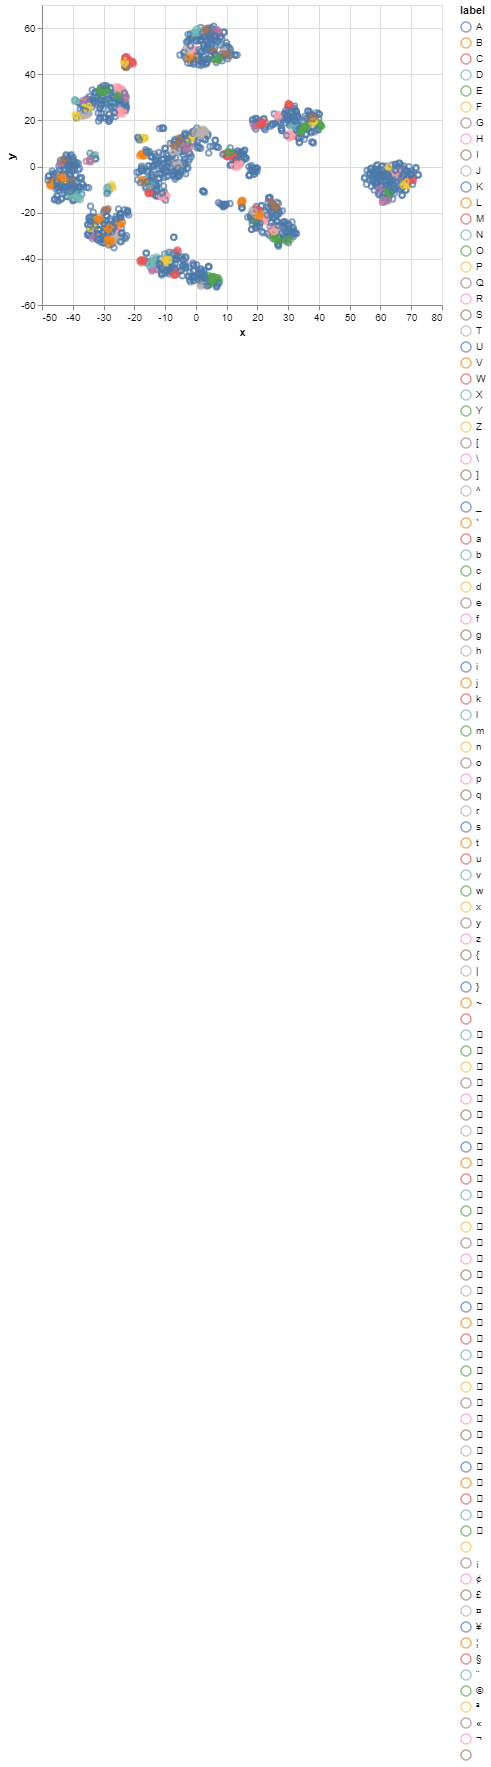

In [7]:
clustering = DBSCAN(eps=1, min_samples=5).fit(ts)

cluster_labels = pd.DataFrame(data=clustering.labels_)

dbscan = pd.DataFrame(ts, columns=['x', 'y'])

dbscan['label'] = cluster_labels.applymap(lambda x: color(x))

dbscan.head()

alt.Chart(dbscan).mark_point().encode(
    x='x',
    y='y',
    color='label'
)

Ahora, volveremos a nuestros datos originales de dimensión 64 para entrenar clasificadores.

En primer lugar, separaremos los datos 70%/30%. Usualmente mezclamos los datos, pero esta vez no lo haremos.

In [8]:
amount = round(len(digits['data']) * 0.7)
training_data, training_labels = (digits['data'][:amount], digits['target'][:amount])
test_data, test_labels = (digits['data'][amount:], digits['target'][amount:])

Entrenaremos un modelo que usa **SGD** o **Stochastic Gradiant Descent** para clasificar por medio de la minimización del error que produce el mismo modelo.

Es importante que para entrenar el modelo **sólo usemos los datos de entrenamiento**. La idea es que el clasificador no pueda ver los datos con los que lo probaremos antes.

In [10]:
sgd = SGDClassifier(max_iter=1000)

sgd.fit(training_data, training_labels)

print('Score modelo con datos de entrenamiento: {}\n'.format(sgd.score(training_data, training_labels)))

print('Score modelo con datos de test: {}\n'.format(sgd.score(test_data, test_labels)))

Score modelo con datos de entrenamiento: 0.972972972972973

Score modelo con datos de test: 0.9016697588126159



El número que nos entrega el método score nos dice que tan bueno es nuestro modelo para predecir. Como pueden ver, el score es muy cercano a 1 cuando lo probamos con datos de entrenamiento, esto es porque el modelo "ya conoce" los datos de entrenamiento, por lo que es importante probarlo con datos que no haya visto antes. Es por esto que para el score usamos los datos de testing que separamos anteriormente.

Ahora veremos una **matriz de confusión**, la cual nos permite visualizar los resultados del modelo.

En una matriz de confusión, el eje X corresponde a la clase verdadera de un dato, mientras que el eje Y corresponde a la clase predecida por el modelo.

In [11]:
test_predict = sgd.predict(test_data)

pd.DataFrame(confusion_matrix(test_labels, test_predict))

,0,1,2,3,4,5,6,7,8,9
0,51,0,0,0,1,0,1,0,0,0
1,0,39,0,0,0,0,0,0,11,3
2,0,0,53,0,0,0,0,0,0,0
3,0,1,0,38,0,2,0,0,12,0
4,0,2,0,0,52,0,1,0,1,0
5,0,0,0,0,0,55,1,0,0,0
6,0,0,0,0,0,0,54,0,0,0
7,0,0,0,0,0,0,0,49,5,0
8,0,1,0,0,0,1,0,0,50,0
9,1,0,0,0,0,1,0,2,6,45


Podemos usar Altair para visualizar mejor la matriz, y vemos que la diagonal posee colores mas claros, significando un mayor valor en ese elemento.

La diagonal corresponde a todos los valores predichos que tienen el mismo valor real. Es decir que estan clasificados correctamente.

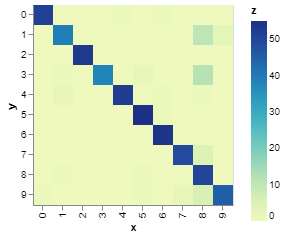

In [12]:
x, y = np.meshgrid(range(0, 10), range(0, 10))
z = confusion_matrix(test_labels, test_predict)

data = pd.DataFrame({'x': x.ravel(),
                     'y': y.ravel(),
                     'z': z.ravel()})

alt.Chart(data).mark_rect().encode(
    x='x:O',
    y='y:O',
    color='z:Q'
)

Ahora, clasificaremos por medio de k-Nearest Neighbors.

In [67]:
knn_n = KNeighborsClassifier(n_neighbors=5, weights="uniform")

knn_n.fit(training_data, training_labels)

knn_n.score(test_data, test_labels)

0.9647495361781077

Entrenamos un segundo modelo, con mucho mayor N.

Podemos ver, al entrenarlo, que el score es bastante menor. Esto es debido a que, al tomar muchos vecinos, termina por tomar datos que son demasiado lejanos al original. Por ende, el resultado no es tan bueno.

In [78]:
knn = KNeighborsClassifier(n_neighbors=1200, weights="uniform")

knn.fit(training_data, training_labels)

knn.score(test_data, test_labels)

0.20037105751391465

Ahora veremos las matrices de confusión de cada modelo.

In [79]:
test_predict_1 = knn_n.predict(test_data)

pd.DataFrame(confusion_matrix(test_labels, test_predict_1))

,0,1,2,3,4,5,6,7,8,9
0,52,0,0,0,1,0,0,0,0,0
1,0,52,0,0,0,0,0,0,0,1
2,1,0,51,1,0,0,0,0,0,0
3,0,0,1,49,0,1,0,1,1,0
4,0,0,0,0,54,0,0,1,1,0
5,0,0,0,0,0,55,1,0,0,0
6,0,0,0,0,0,0,54,0,0,0
7,0,0,0,0,0,0,0,54,0,0
8,0,3,0,0,0,0,0,1,47,1
9,0,0,0,1,0,2,0,0,0,52


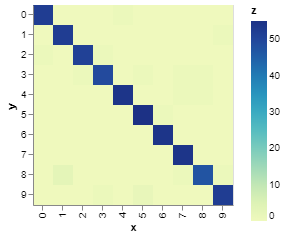

In [72]:
x, y = np.meshgrid(range(0, 10), range(0, 10))
z = confusion_matrix(test_labels, test_predict_1)

data = pd.DataFrame({'x': x.ravel(),
                     'y': y.ravel(),
                     'z': z.ravel()})

alt.Chart(data).mark_rect().encode(
    x='x:O',
    y='y:O',
    color='z:Q'
)

In [80]:
test_predict_2 = knn.predict(test_data)

pd.DataFrame(confusion_matrix(test_labels, test_predict_2))

,0,1,2,3,4,5,6,7,8,9
0,0,4,0,45,0,0,4,0,0,0
1,0,19,0,23,0,0,11,0,0,0
2,0,0,0,53,0,0,0,0,0,0
3,0,3,0,50,0,0,0,0,0,0
4,0,40,0,5,0,1,10,0,0,0
5,0,0,0,38,0,5,13,0,0,0
6,0,18,0,3,0,0,33,0,0,0
7,0,0,0,51,0,1,1,1,0,0
8,2,5,0,32,0,3,10,0,0,0
9,0,3,0,51,0,1,0,0,0,0


Podemos observar que el segundo modelo tiene una matriz de confusión mucho menos diagonal, significando muchos errores de clasificación.

Para visualizar mejor, nuevamente mostraremos las matrices por medio de altair. Podemos observar de mejor manera la diferencia de los modelos frente a un cambio de parámetros.

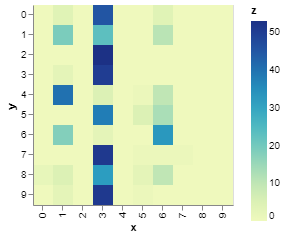

In [81]:
x, y = np.meshgrid(range(0, 10), range(0, 10))
z = confusion_matrix(test_labels, test_predict_2)

data = pd.DataFrame({'x': x.ravel(),
                     'y': y.ravel(),
                     'z': z.ravel()})

alt.Chart(data).mark_rect().encode(
    x='x:O',
    y='y:O',
    color='z:Q'
)